In [1]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.models.segmentation import fcn_resnet50
from tqdm import tqdm
from torchinfo import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# Define transformations for SimCLR
class SimCLRTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
    def __call__(self, x):
        return self.transform(x), self.transform(x)

In [3]:
# Dataset for SimCLR
class ButterflyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            return self.transform(image)
        return image

In [4]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ProjectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x
    
class SimCLR(nn.Module):
    def __init__(self, base_model, projection_dim):
        super(SimCLR, self).__init__()
        self.encoder = base_model
        self.encoder.fc = nn.Identity()  # Remove the classification head
        self.projection_head = ProjectionHead(512, 256, projection_dim)

    def forward(self, x):
        h = self.encoder(x)
        z = self.projection_head(h)
        return h, z
    
def nt_xent_loss(z_i, z_j, temperature=0.5):
    batch_size = z_i.shape[0]
    z = torch.cat([z_i, z_j], dim=0).to(device)  # Concatenate positives

    # Compute cosine similarity matrix
    sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=-1).to(device)

    # Temperature scaling and masking
    sim = sim / temperature
    mask = torch.eye(2 * batch_size, dtype=torch.bool).to(device)
    sim = sim.masked_fill(mask, float('-inf'))  # Set self-similarities to -inf

    # Compute numerator (positive pairs)
    pos_sim = torch.exp(F.cosine_similarity(z_i, z_j, dim=-1) / temperature).to(device)

    # Compute denominator (sum over all except self-similarities)
    denom = torch.exp(sim).sum(dim=-1)

    # Compute NT-Xent loss
    loss = -torch.log(pos_sim / denom[:batch_size])  # Use correct batch indexing
    return loss.mean()

In [5]:
# Load dataset
data_dir = "./Butterfly_Dataset/train/"
simclr_transform = SimCLRTransform()
butterfly_dataset = ButterflyDataset(data_dir, transform=simclr_transform)
simclr_loader = DataLoader(butterfly_dataset, batch_size=64, shuffle=True, num_workers=4)


In [6]:
# Initialize SimCLR model
batch_size = 64
base_model = models.resnet18(weights=None).to(device)
simclr_model = SimCLR(base_model, projection_dim=128).to(device)
print(summary(simclr_model, input_size=(batch_size, 3, 224, 224)))



Layer (type:depth-idx)                        Output Shape              Param #
SimCLR                                        [64, 512]                 --
├─ResNet: 1-1                                 [64, 512]                 --
│    └─Conv2d: 2-1                            [64, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                       [64, 64, 112, 112]        128
│    └─ReLU: 2-3                              [64, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [64, 64, 56, 56]          --
│    └─Sequential: 2-5                        [64, 64, 56, 56]          --
│    │    └─BasicBlock: 3-1                   [64, 64, 56, 56]          73,984
│    │    └─BasicBlock: 3-2                   [64, 64, 56, 56]          73,984
│    └─Sequential: 2-6                        [64, 128, 28, 28]         --
│    │    └─BasicBlock: 3-3                   [64, 128, 28, 28]         230,144
│    │    └─BasicBlock: 3-4                   [64, 128, 28, 28]         295,42

In [7]:
optimizer = optim.Adam(simclr_model.parameters(), lr=3e-4)
epochs = 100
loss_lst = []
simclr_model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for (x_i, x_j) in tqdm(simclr_loader):
        x_i, x_j = x_i.to(device), x_j.to(device)
        _, z_i = simclr_model(x_i)
        _, z_j = simclr_model(x_j)
        loss = nt_xent_loss(z_i, z_j)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(simclr_loader)}")
    loss_lst.append(epoch_loss/len(simclr_loader))
    torch.save(simclr_model.state_dict(), 'simclr_V1'+'.pt')


100%|██████████| 102/102 [00:19<00:00,  5.33it/s]


Epoch [1/100], Loss: 4.197007859454436


100%|██████████| 102/102 [00:18<00:00,  5.52it/s]


Epoch [2/100], Loss: 3.8794292655645632


100%|██████████| 102/102 [00:18<00:00,  5.38it/s]


Epoch [3/100], Loss: 3.7558836843453203


100%|██████████| 102/102 [00:19<00:00,  5.31it/s]


Epoch [4/100], Loss: 3.668503999710083


100%|██████████| 102/102 [00:19<00:00,  5.31it/s]


Epoch [5/100], Loss: 3.6171848002602074


100%|██████████| 102/102 [00:19<00:00,  5.35it/s]


Epoch [6/100], Loss: 3.5795588166105983


100%|██████████| 102/102 [00:18<00:00,  5.40it/s]


Epoch [7/100], Loss: 3.547021108515122


100%|██████████| 102/102 [00:19<00:00,  5.19it/s]


Epoch [8/100], Loss: 3.5163635062236414


100%|██████████| 102/102 [00:19<00:00,  5.29it/s]


Epoch [9/100], Loss: 3.4966334548651004


100%|██████████| 102/102 [00:19<00:00,  5.17it/s]


Epoch [10/100], Loss: 3.4798225935767677


100%|██████████| 102/102 [00:19<00:00,  5.35it/s]


Epoch [11/100], Loss: 3.461595998090856


100%|██████████| 102/102 [00:19<00:00,  5.29it/s]


Epoch [12/100], Loss: 3.455914675020704


100%|██████████| 102/102 [00:18<00:00,  5.43it/s]


Epoch [13/100], Loss: 3.4435337805280497


100%|██████████| 102/102 [00:19<00:00,  5.34it/s]


Epoch [14/100], Loss: 3.432615752313651


100%|██████████| 102/102 [00:18<00:00,  5.48it/s]


Epoch [15/100], Loss: 3.429905615600885


100%|██████████| 102/102 [00:18<00:00,  5.44it/s]


Epoch [16/100], Loss: 3.4226283746607162


100%|██████████| 102/102 [00:18<00:00,  5.38it/s]


Epoch [17/100], Loss: 3.4024800062179565


100%|██████████| 102/102 [00:18<00:00,  5.45it/s]


Epoch [18/100], Loss: 3.404824175086676


100%|██████████| 102/102 [00:18<00:00,  5.47it/s]


Epoch [19/100], Loss: 3.3826833332286164


100%|██████████| 102/102 [00:18<00:00,  5.51it/s]


Epoch [20/100], Loss: 3.38787661112991


100%|██████████| 102/102 [00:18<00:00,  5.44it/s]


Epoch [21/100], Loss: 3.3719249706642302


100%|██████████| 102/102 [00:19<00:00,  5.34it/s]


Epoch [22/100], Loss: 3.3698075495514215


100%|██████████| 102/102 [00:18<00:00,  5.59it/s]


Epoch [23/100], Loss: 3.3616823448854336


100%|██████████| 102/102 [00:18<00:00,  5.43it/s]


Epoch [24/100], Loss: 3.364581105755825


100%|██████████| 102/102 [00:18<00:00,  5.60it/s]


Epoch [25/100], Loss: 3.34707996190763


100%|██████████| 102/102 [00:18<00:00,  5.52it/s]


Epoch [26/100], Loss: 3.3405893222958434


100%|██████████| 102/102 [00:19<00:00,  5.36it/s]


Epoch [27/100], Loss: 3.324095510968975


100%|██████████| 102/102 [00:19<00:00,  5.29it/s]


Epoch [28/100], Loss: 3.334526155509201


100%|██████████| 102/102 [00:18<00:00,  5.43it/s]


Epoch [29/100], Loss: 3.338055545208501


100%|██████████| 102/102 [00:18<00:00,  5.39it/s]


Epoch [30/100], Loss: 3.322492566763186


100%|██████████| 102/102 [00:18<00:00,  5.37it/s]


Epoch [31/100], Loss: 3.32131556669871


100%|██████████| 102/102 [00:18<00:00,  5.41it/s]


Epoch [32/100], Loss: 3.3101781770294787


100%|██████████| 102/102 [00:18<00:00,  5.47it/s]


Epoch [33/100], Loss: 3.306079200669831


100%|██████████| 102/102 [00:19<00:00,  5.35it/s]


Epoch [34/100], Loss: 3.306158939997355


100%|██████████| 102/102 [00:19<00:00,  5.35it/s]


Epoch [35/100], Loss: 3.3009470023360907


100%|██████████| 102/102 [00:18<00:00,  5.41it/s]


Epoch [36/100], Loss: 3.2985198497772217


100%|██████████| 102/102 [00:19<00:00,  5.32it/s]


Epoch [37/100], Loss: 3.2941464746699616


100%|██████████| 102/102 [00:18<00:00,  5.38it/s]


Epoch [38/100], Loss: 3.294102979641335


100%|██████████| 102/102 [00:18<00:00,  5.41it/s]


Epoch [39/100], Loss: 3.2913332429586672


100%|██████████| 102/102 [00:18<00:00,  5.45it/s]


Epoch [40/100], Loss: 3.2806008913937736


100%|██████████| 102/102 [00:19<00:00,  5.30it/s]


Epoch [41/100], Loss: 3.2717618030660294


100%|██████████| 102/102 [00:19<00:00,  5.30it/s]


Epoch [42/100], Loss: 3.270908991495768


100%|██████████| 102/102 [00:18<00:00,  5.48it/s]


Epoch [43/100], Loss: 3.2877435871199068


100%|██████████| 102/102 [00:18<00:00,  5.63it/s]


Epoch [44/100], Loss: 3.279944976170858


100%|██████████| 102/102 [00:18<00:00,  5.59it/s]


Epoch [45/100], Loss: 3.268328442293055


100%|██████████| 102/102 [00:18<00:00,  5.60it/s]


Epoch [46/100], Loss: 3.262138189054003


100%|██████████| 102/102 [00:18<00:00,  5.54it/s]


Epoch [47/100], Loss: 3.258095811395084


100%|██████████| 102/102 [00:18<00:00,  5.62it/s]


Epoch [48/100], Loss: 3.261563927519555


100%|██████████| 102/102 [00:18<00:00,  5.65it/s]


Epoch [49/100], Loss: 3.25604816979053


100%|██████████| 102/102 [00:18<00:00,  5.60it/s]


Epoch [50/100], Loss: 3.252420745643915


100%|██████████| 102/102 [00:18<00:00,  5.66it/s]


Epoch [51/100], Loss: 3.2503403799206603


100%|██████████| 102/102 [00:18<00:00,  5.58it/s]


Epoch [52/100], Loss: 3.2576196380690035


100%|██████████| 102/102 [00:18<00:00,  5.52it/s]


Epoch [53/100], Loss: 3.253471337112726


100%|██████████| 102/102 [00:18<00:00,  5.58it/s]


Epoch [54/100], Loss: 3.24602145540948


100%|██████████| 102/102 [00:18<00:00,  5.63it/s]


Epoch [55/100], Loss: 3.24595897805457


100%|██████████| 102/102 [00:18<00:00,  5.62it/s]


Epoch [56/100], Loss: 3.249614629091001


100%|██████████| 102/102 [00:18<00:00,  5.62it/s]


Epoch [57/100], Loss: 3.2344790089364146


100%|██████████| 102/102 [00:18<00:00,  5.66it/s]


Epoch [58/100], Loss: 3.251481439553055


100%|██████████| 102/102 [00:18<00:00,  5.56it/s]


Epoch [59/100], Loss: 3.230571905771891


100%|██████████| 102/102 [00:18<00:00,  5.57it/s]


Epoch [60/100], Loss: 3.2303458592470955


100%|██████████| 102/102 [00:18<00:00,  5.47it/s]


Epoch [61/100], Loss: 3.2339315204059376


100%|██████████| 102/102 [00:18<00:00,  5.57it/s]


Epoch [62/100], Loss: 3.2324211036457733


100%|██████████| 102/102 [00:18<00:00,  5.61it/s]


Epoch [63/100], Loss: 3.2319493060018503


100%|██████████| 102/102 [00:17<00:00,  5.68it/s]


Epoch [64/100], Loss: 3.2238506242340685


100%|██████████| 102/102 [00:18<00:00,  5.64it/s]


Epoch [65/100], Loss: 3.2236140498927996


100%|██████████| 102/102 [00:18<00:00,  5.58it/s]


Epoch [66/100], Loss: 3.229950128817091


100%|██████████| 102/102 [00:18<00:00,  5.64it/s]


Epoch [67/100], Loss: 3.218498893812591


100%|██████████| 102/102 [00:18<00:00,  5.55it/s]


Epoch [68/100], Loss: 3.22364299437579


100%|██████████| 102/102 [00:18<00:00,  5.62it/s]


Epoch [69/100], Loss: 3.2181696260676667


100%|██████████| 102/102 [00:18<00:00,  5.58it/s]


Epoch [70/100], Loss: 3.2240766123229383


100%|██████████| 102/102 [00:18<00:00,  5.59it/s]


Epoch [71/100], Loss: 3.2181188592723773


100%|██████████| 102/102 [00:18<00:00,  5.56it/s]


Epoch [72/100], Loss: 3.2133674925448847


100%|██████████| 102/102 [00:18<00:00,  5.51it/s]


Epoch [73/100], Loss: 3.2110740226857803


100%|██████████| 102/102 [00:18<00:00,  5.66it/s]


Epoch [74/100], Loss: 3.2058133307625267


100%|██████████| 102/102 [00:18<00:00,  5.59it/s]


Epoch [75/100], Loss: 3.201712362906512


100%|██████████| 102/102 [00:18<00:00,  5.56it/s]


Epoch [76/100], Loss: 3.200688574828354


100%|██████████| 102/102 [00:18<00:00,  5.63it/s]


Epoch [77/100], Loss: 3.209414563926996


100%|██████████| 102/102 [00:18<00:00,  5.49it/s]


Epoch [78/100], Loss: 3.207339226030836


100%|██████████| 102/102 [00:18<00:00,  5.64it/s]


Epoch [79/100], Loss: 3.209930095018125


100%|██████████| 102/102 [00:18<00:00,  5.56it/s]


Epoch [80/100], Loss: 3.199019796708051


100%|██████████| 102/102 [00:18<00:00,  5.63it/s]


Epoch [81/100], Loss: 3.1917937947254553


100%|██████████| 102/102 [00:18<00:00,  5.61it/s]


Epoch [82/100], Loss: 3.200031689569062


100%|██████████| 102/102 [00:18<00:00,  5.57it/s]


Epoch [83/100], Loss: 3.197877566019694


100%|██████████| 102/102 [00:18<00:00,  5.63it/s]


Epoch [84/100], Loss: 3.190312154152814


100%|██████████| 102/102 [00:18<00:00,  5.53it/s]


Epoch [85/100], Loss: 3.186334899827546


100%|██████████| 102/102 [00:18<00:00,  5.65it/s]


Epoch [86/100], Loss: 3.1929705727334117


100%|██████████| 102/102 [00:18<00:00,  5.63it/s]


Epoch [87/100], Loss: 3.189003862586676


100%|██████████| 102/102 [00:18<00:00,  5.61it/s]


Epoch [88/100], Loss: 3.185753763890734


100%|██████████| 102/102 [00:18<00:00,  5.57it/s]


Epoch [89/100], Loss: 3.182714731085534


100%|██████████| 102/102 [00:18<00:00,  5.50it/s]


Epoch [90/100], Loss: 3.192695421331069


100%|██████████| 102/102 [00:18<00:00,  5.56it/s]


Epoch [91/100], Loss: 3.1880802453732957


100%|██████████| 102/102 [00:18<00:00,  5.52it/s]


Epoch [92/100], Loss: 3.1805553389530554


100%|██████████| 102/102 [00:18<00:00,  5.51it/s]


Epoch [93/100], Loss: 3.1950320192411836


100%|██████████| 102/102 [00:18<00:00,  5.55it/s]


Epoch [94/100], Loss: 3.1775550818910787


100%|██████████| 102/102 [00:18<00:00,  5.60it/s]


Epoch [95/100], Loss: 3.18014895214754


100%|██████████| 102/102 [00:18<00:00,  5.49it/s]


Epoch [96/100], Loss: 3.1763687297409655


100%|██████████| 102/102 [00:18<00:00,  5.59it/s]


Epoch [97/100], Loss: 3.175664354773129


100%|██████████| 102/102 [00:18<00:00,  5.49it/s]


Epoch [98/100], Loss: 3.170699084506315


100%|██████████| 102/102 [00:18<00:00,  5.63it/s]


Epoch [99/100], Loss: 3.161847617111954


100%|██████████| 102/102 [00:18<00:00,  5.57it/s]


Epoch [100/100], Loss: 3.1801244043836405


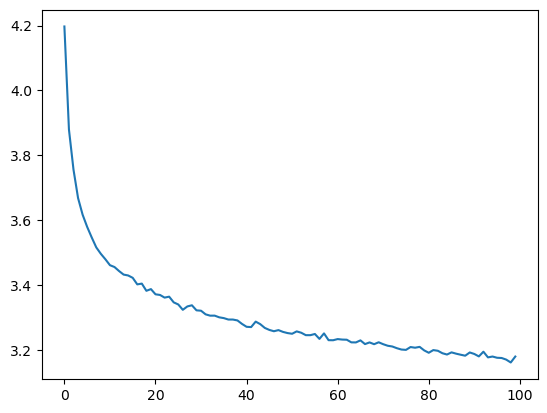

In [8]:
import matplotlib.pyplot as plt
plt.plot(loss_lst)

In [7]:
simclr_model_state_dict = torch.load('simclr_V1.pt',weights_only=True)
base_model = models.resnet18(weights=None).to(device)
simclr_model = SimCLR(base_model, projection_dim=128).to(device)
simclr_model.load_state_dict(simclr_model_state_dict)
batch_size = 64
print(summary(simclr_model, input_size=(batch_size, 3, 224, 224)))

Layer (type:depth-idx)                        Output Shape              Param #
SimCLR                                        [64, 512]                 --
├─ResNet: 1-1                                 [64, 512]                 --
│    └─Conv2d: 2-1                            [64, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                       [64, 64, 112, 112]        128
│    └─ReLU: 2-3                              [64, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [64, 64, 56, 56]          --
│    └─Sequential: 2-5                        [64, 64, 56, 56]          --
│    │    └─BasicBlock: 3-1                   [64, 64, 56, 56]          73,984
│    │    └─BasicBlock: 3-2                   [64, 64, 56, 56]          73,984
│    └─Sequential: 2-6                        [64, 128, 28, 28]         --
│    │    └─BasicBlock: 3-3                   [64, 128, 28, 28]         230,144
│    │    └─BasicBlock: 3-4                   [64, 128, 28, 28]         295,42

In [8]:
class SegmentationModel(nn.Module):
    def __init__(self, simclr_model, num_classes=1):
        super(SegmentationModel, self).__init__()
        
        # Use SimCLR-trained encoder (ResNet-18 without projection head)
        self.encoder = simclr_model.encoder
        self.encoder.fc = nn.Identity()  # Remove classification head
        
        # Decoder (U-Net style upsampling)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),   # 1x1 → 2x2
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),   # 2x2 → 4x4
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),    # 4x4 → 8x8
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),     # 8x8 → 16x16
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),     # 16x16 → 32x32
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),      # 32x32 → 64x64
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=1),       # 64x64 → 128x128
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(4, 2, kernel_size=4, stride=2, padding=1),       # 128x128 → 256x256
            nn.ReLU(inplace=True),
            nn.Conv2d(2, 1, kernel_size=3, padding=1),                          # 256x256 → 256x256, refine
            nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False) # Crop/resize to exact 224x224
)

    def forward(self, x):
        x = self.encoder(x)  # Feature extractor
        x = x.view(x.shape[0], 512, 1, 1)  # Reshape for decoder
        x = self.decoder(x)
        x = torch.sigmoid(x)  # Normalize to [0,1] range
        return x

In [9]:
segmentation_model = SegmentationModel(simclr_model).to(device) # Enoder stored weights are taken
batch_size = 64
print(summary(segmentation_model, input_size=(batch_size, 3, 224, 224)))

Layer (type:depth-idx)                        Output Shape              Param #
SegmentationModel                             [64, 1, 224, 224]         --
├─ResNet: 1-1                                 [64, 512]                 --
│    └─Conv2d: 2-1                            [64, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                       [64, 64, 112, 112]        128
│    └─ReLU: 2-3                              [64, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [64, 64, 56, 56]          --
│    └─Sequential: 2-5                        [64, 64, 56, 56]          --
│    │    └─BasicBlock: 3-1                   [64, 64, 56, 56]          73,984
│    │    └─BasicBlock: 3-2                   [64, 64, 56, 56]          73,984
│    └─Sequential: 2-6                        [64, 128, 28, 28]         --
│    │    └─BasicBlock: 3-3                   [64, 128, 28, 28]         230,144
│    │    └─BasicBlock: 3-4                   [64, 128, 28, 28]         295,42

In [10]:
# Segmentation Dataset and Loader
class SegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = [fname.replace('.jpg','_mask.png') for fname in self.images]
        print(self.images)
        print(self.masks)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.image_dir + self.images[idx]
        mask_path = self.mask_dir + self.masks[idx]
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

imageT = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])
maskT = transforms.Compose([transforms.ToTensor()])
dataset_train = SegDataset(image_dir='./SegmentedDataset/train_images/', 
                           mask_dir='./SegmentedDataset/train_masks/',
                           image_transform = imageT,
                           mask_transform = maskT)
dataset_val = SegDataset(image_dir='./SegmentedDataset/validation_images/', 
                           mask_dir='./SegmentedDataset/validation_masks/',
                           image_transform = imageT,
                           mask_transform = maskT)
dataset_test = SegDataset(image_dir='./SegmentedDataset/test_images/', 
                           mask_dir='./SegmentedDataset/test_masks/',
                           image_transform = imageT,
                           mask_transform = maskT)


train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)


    

['Image_1.jpg', 'Image_10.jpg', 'Image_100.jpg', 'Image_101.jpg', 'Image_102.jpg', 'Image_103.jpg', 'Image_104.jpg', 'Image_105.jpg', 'Image_106.jpg', 'Image_107.jpg', 'Image_108.jpg', 'Image_109.jpg', 'Image_11.jpg', 'Image_110.jpg', 'Image_111.jpg', 'Image_112.jpg', 'Image_113.jpg', 'Image_114.jpg', 'Image_115.jpg', 'Image_116.jpg', 'Image_117.jpg', 'Image_118.jpg', 'Image_119.jpg', 'Image_12.jpg', 'Image_120.jpg', 'Image_13.jpg', 'Image_14.jpg', 'Image_15.jpg', 'Image_16.jpg', 'Image_17.jpg', 'Image_18.jpg', 'Image_19.jpg', 'Image_2.jpg', 'Image_20.jpg', 'Image_3.jpg', 'Image_4.jpg', 'Image_41.jpg', 'Image_42.jpg', 'Image_43.jpg', 'Image_44.jpg', 'Image_45.jpg', 'Image_46.jpg', 'Image_47.jpg', 'Image_48.jpg', 'Image_49.jpg', 'Image_5.jpg', 'Image_50.jpg', 'Image_51.jpg', 'Image_52.jpg', 'Image_53.jpg', 'Image_54.jpg', 'Image_55.jpg', 'Image_56.jpg', 'Image_57.jpg', 'Image_58.jpg', 'Image_59.jpg', 'Image_6.jpg', 'Image_60.jpg', 'Image_61.jpg', 'Image_62.jpg', 'Image_63.jpg', 'Image_6

torch.Size([8, 3, 224, 224])
torch.Size([8, 1, 224, 224])
Display Data torch.Size([16, 3, 224, 224])
Display Grid torch.Size([3, 906, 906])
tensor(1.)


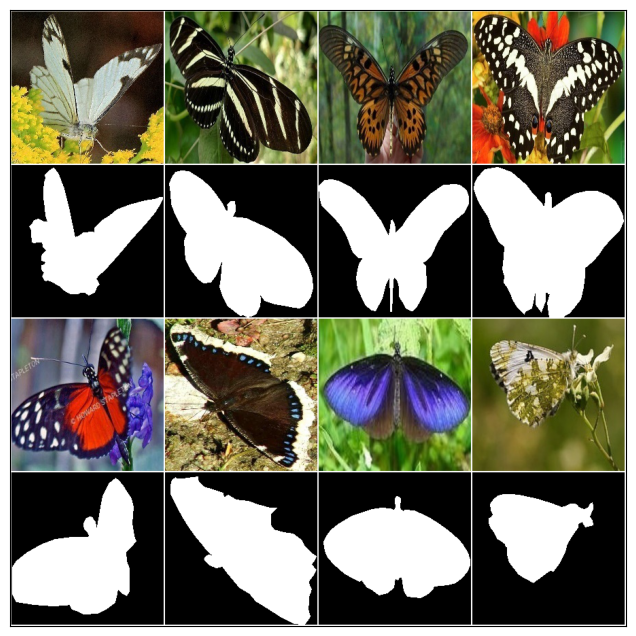

In [13]:
def imshow(imgs,w=8,h=8):
    #imgs = imgs / 2 + 0.5
    #print('imgs',np.shape(imgs))
    npimgs = imgs.to('cpu')
    npimgs = npimgs.numpy()
    #print('npimgs',np.shape(npimgs))
    plt.figure(figsize=(w,h))
    plt.xticks([])
    plt.yticks([])
    #plt.imshow(npimgs)
    plt.imshow(np.transpose(npimgs, (1, 2, 0)))
    plt.show()

def interspace_images_masks(images,masks,total=16,height=224,width=224,channels=3):
    final = torch.zeros(total,channels,height,width)
    imagesx = images / 2 + 0.5
    for i in range(8):
        idx = 8*(i//4)+(i%4)
        final[idx,:,:,:] = imagesx[i,:,:,:]
    for i in range(8):
        idx = 8*(i//4)+(i%4) + 4
        final[idx,:,:,:] = masks[i,:,:,:]
    return final

def interspace_images_masks_output(images,outputs,masks,total=18,height=224,width=224,channels=3):
    final = torch.zeros(total,channels,height,width)
    imagesx = images/2 + 0.5
    for i in range(6):
        final[i,:,:,:] = imagesx[i,:,:,:]
        final[(i+6),:,:,:] = masks[i,:,:,:]
        final[(i+12),:,:,:] = outputs[i,:,:,:]
    return final


visual_loader = DataLoader(dataset_test, batch_size=8, shuffle=False) 
dataiter = iter(visual_loader)
images,masks = next(dataiter)  

print(np.shape(images))
print(np.shape(masks))
display_data = interspace_images_masks(images,masks,channels=3)
print('Display Data',np.shape(display_data))
display_grid = torchvision.utils.make_grid(display_data, nrow=4,pad_value=1.0)
print('Display Grid',np.shape(display_grid))
print(torch.max(display_grid))
imshow(display_grid)

#### Training segmentation model by freezing encoder weights, with dice loss as loss function

In [14]:
print(summary(segmentation_model.encoder, input_size=(batch_size, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 512]                 --
├─Conv2d: 1-1                            [64, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [64, 64, 112, 112]        128
├─ReLU: 1-3                              [64, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [64, 64, 56, 56]          --
├─Sequential: 1-5                        [64, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [64, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [64, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [64, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [64, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [64, 64, 56, 56]          --
│

In [ ]:
import time


class DiceLoss(nn.Module):
    def __init__(self, epsilon=1e-6):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, output, target):
        output = output.contiguous().view(-1)
        target = target.contiguous().view(-1)
        intersection = (output * target).sum()
        dice_coefficient = (2. * intersection + self.epsilon) / (output.sum() + target.sum() + self.epsilon)
        return 1 - dice_coefficient



def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():  # No need to compute gradients during evaluation
        for data, target in test_loader:
            cur_batch_size = data.size(0)
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += (criterion(output, target).item()*cur_batch_size)  # Sum up batch loss

    test_loss /= len(test_loader.dataset)
    #accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.8f}')

def plot_losses(train_losses, val_losses, best_epoch,loss_func_name,learning_rate):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b.-', label='Training Loss')  # 'bo-' for blue circles on the line
    plt.plot(epochs, val_losses, 'r.-', label='Validation Loss')  # 'ro-' for red circles on the line
    
    # Mark the best model epoch on the validation loss curve with 'X' marker
    plt.scatter(best_epoch + 1, val_losses[best_epoch], color='green', marker='x', s=100, label='Best Model')

    plt.xlabel('Epochs')
    plt.ylabel(loss_func_name)
    plt.title('Training and Validation Loss Curves' + '(LR = ' + str(learning_rate) +')')
    plt.legend()
    plt.grid(True)
    plt.show()


def validate(model, device, val_loader, criterion):
    model.eval()  # Evaluation mode
    val_loss = 0
    correct = 0
    with torch.no_grad():  # No need to compute gradients during validation
        for data, target in val_loader:
            cur_batch_size = data.size(0)
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += (criterion(output, target).item()*cur_batch_size)  # Sum up batch loss

    val_loss /= len(val_loader.dataset)
    return val_loss

def train_and_validate(model, device, train_loader, val_loader, optimizer, criterion, num_epochs):
    best_val_loss = float('inf')  # Initialize best validation loss to infinity
    best_model = None
    best_epoch = 0  # Track which epoch had the best validation loss

    train_losses = []  # Store training loss for each epoch
    val_losses = []    # Store validation loss for each epoch

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()  # Training mode
        running_loss = 0.0

        for batch_idx, (data, target) in enumerate(train_loader):
            cur_batch_size = data.size(0)
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()  # Zero the gradients
            output = model(data)   # Forward pass
            loss = criterion(output, target)  # Compute loss
            #print(loss.item(),end='')
            loss.backward()        # Backpropagation
            optimizer.step()       # Update weights
            running_loss += (loss.item()*cur_batch_size)
            print('=',end='')

        train_loss = running_loss / len(train_loader.dataset)  # Average training loss for the epoch
        train_losses.append(train_loss)  # Save training loss

        # Validate the model after each epoch
        val_loss = validate(model, device, val_loader, criterion)
        val_losses.append(val_loss)  # Save validation loss
        end_time = time.time()
        print('   Time : ',np.round(end_time-start_time),' Sec')
        print('Epoch : ',(epoch+1),'   Train Loss : ',np.round(train_loss,8),'   Validation Loss : ',np.round(val_loss,8))

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch  # Track the epoch with the best validation loss
            best_model = model.state_dict()  # Save the best model's state_dict
            torch.save(best_model, PATH)
            print(f'Best model saved with validation loss: {best_val_loss:.8f}')

    return train_losses,val_losses,best_epoch

simclr_model_state_dict = torch.load('simclr_V1.pt',weights_only=True)
base_model = models.resnet18(weights=None).to(device)
simclr_model = SimCLR(base_model, projection_dim=128).to(device)
simclr_model.load_state_dict(simclr_model_state_dict)
batch_size = 64
segmentation_model = SegmentationModel(simclr_model).to(device) # Enoder stored weights are taken

learning_rate = 0.001
loss_func_name = 'Dice Loss'
criterion = DiceLoss()
# Freeze encoder weights
for param in segmentation_model.encoder.parameters():
    param.requires_grad = False
# Optimize only on decoder weights
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, segmentation_model.parameters()), lr=learning_rate)
num_epochs = 1000
PATH = 'segmodel_V1.pt'
train_losses, val_losses, best_epoch = train_and_validate(segmentation_model, device, train_loader, val_loader, optimizer, criterion, num_epochs)

====   Time :  1.0  Sec
Epoch :  1    Train Loss :  0.5198088    Validation Loss :  0.50222993
Best model saved with validation loss: 0.50222993
====   Time :  0.0  Sec
Epoch :  2    Train Loss :  0.51934806    Validation Loss :  0.50181913
Best model saved with validation loss: 0.50181913
====   Time :  0.0  Sec
Epoch :  3    Train Loss :  0.51880048    Validation Loss :  0.5014106
Best model saved with validation loss: 0.50141060
====   Time :  0.0  Sec
Epoch :  4    Train Loss :  0.51858341    Validation Loss :  0.50100148
Best model saved with validation loss: 0.50100148
====   Time :  0.0  Sec
Epoch :  5    Train Loss :  0.51801935    Validation Loss :  0.50059378
Best model saved with validation loss: 0.50059378
====   Time :  0.0  Sec
Epoch :  6    Train Loss :  0.51790828    Validation Loss :  0.50018454
Best model saved with validation loss: 0.50018454
====   Time :  0.0  Sec
Epoch :  7    Train Loss :  0.51724813    Validation Loss :  0.49977398
Best model saved with validati

KeyboardInterrupt: 

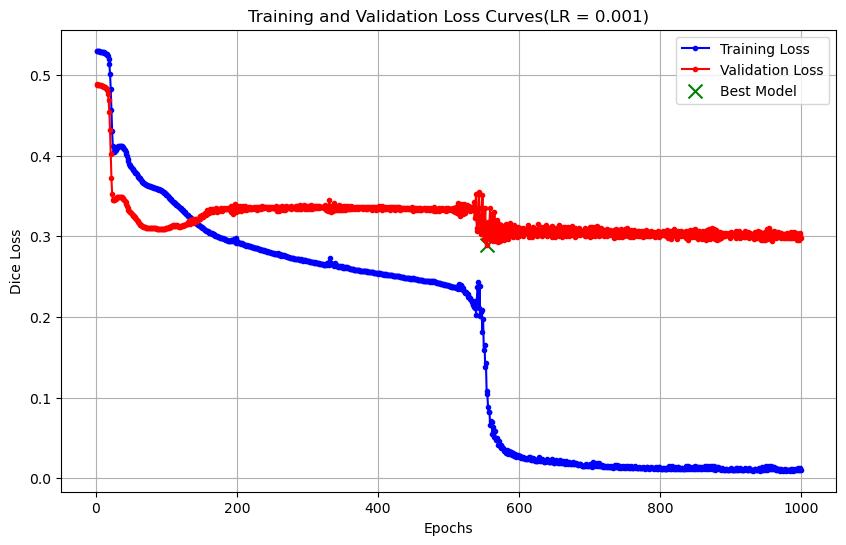

Best model loaded!
Test set: Average loss: 0.27351010


In [16]:
PATH = 'segmodel_V1.pt'
plot_losses(train_losses, val_losses, best_epoch, loss_func_name,learning_rate)
segmentation_model.load_state_dict(torch.load(PATH, weights_only=True))
print("Best model loaded!")   
test(segmentation_model, device, test_loader, criterion)

In [17]:
from sklearn.metrics import roc_curve, auc
def all_metrics(pred,gt,th):
    pred_sel = (pred>=th)*1
    tpr_arr = ((pred_sel==gt) & (gt==1))*1
    tnr_arr = ((pred_sel==gt) & (gt==0))*1
    tp = np.sum(tpr_arr)
    tn = np.sum(tnr_arr)
    pp = np.sum(pred_sel)
    gtp = np.sum(gt)
    dice_score = (2*tp)/(pp+gtp)
    accuracy = (tp+tn)/len(gt)
    tpr = tp/gtp
    precision = tp/pp
    return np.round(dice_score,4), np.round(accuracy,4), np.round(tpr,4), np.round(precision,4)


def show_results(seg_model,test_loader,ht=224,wd=224,ch=1,to_display=6):
    seg_model.eval()
    target_arr = torch.empty(0).to(device)
    output_arr = torch.empty(0).to(device)
    disp_images = torch.zeros(to_display,ch,ht,wd)
    disp_masks = torch.zeros(to_display,ch,ht,wd)
    disp_outputs = torch.zeros(to_display,ch,ht,wd)
    
    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch_idx,(data, target) in enumerate(test_loader):
            cur_batch_size = data.size(0)
            data, target = data.to(device), target.to(device)
            output = seg_model(data)
            if(batch_idx==0):
                disp_images[:,:,:,:] = data[0:to_display,:,:,:]
                disp_masks[:,:,:,:] = target[0:to_display,:,:,:]
                disp_outputs[:,:,:,:] = output[0:to_display,:,:,:]
            target_arr = torch.cat((target_arr,torch.ravel(target)),0)
            output_arr = torch.cat((output_arr,torch.ravel(output)),0)
        y_test = target_arr.cpu().detach().numpy()
        y_pred_prob = output_arr.cpu().detach().numpy()
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(4,4))  
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve Segmention')
        plt.legend()
        plt.show()
        j_scores = tpr - fpr
        best_threshold_index = np.argmax(j_scores)
        best_threshold = thresholds[best_threshold_index]
        print('Best Threshold : ',best_threshold)
        #print('TPR direct : ', tpr[best_threshold_index])
        use_threshold = best_threshold
        #use_threshold = 0.008
        dice_score, accuracy, tpr, precision =  all_metrics(pred=y_pred_prob,gt=y_test,th=use_threshold)
        print('Dice Score : ',dice_score)
        print('Accuracy : ',accuracy)
        print('TPR : ',tpr)
        print('Precision : ',precision)
        disp_outputs = (disp_outputs>=use_threshold)*1
        display_data = interspace_images_masks_output(disp_images,disp_masks,disp_outputs,total=to_display*3,height=ht,width=wd,channels=ch)
        display_grid = torchvision.utils.make_grid(display_data, nrow=6,pad_value=1.0)
        #print('Display Grid',np.shape(display_grid))
        #print(torch.max(display_grid))
        imshow(display_grid,12,6)

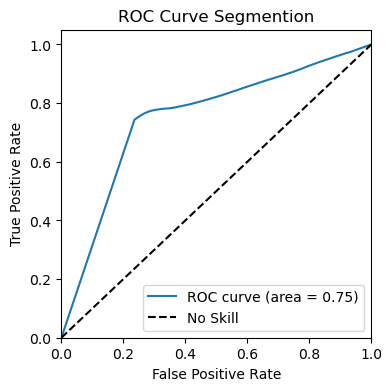

Best Threshold :  1.0
Dice Score :  0.7421
Accuracy :  0.7542
TPR :  0.7433
Precision :  0.7409


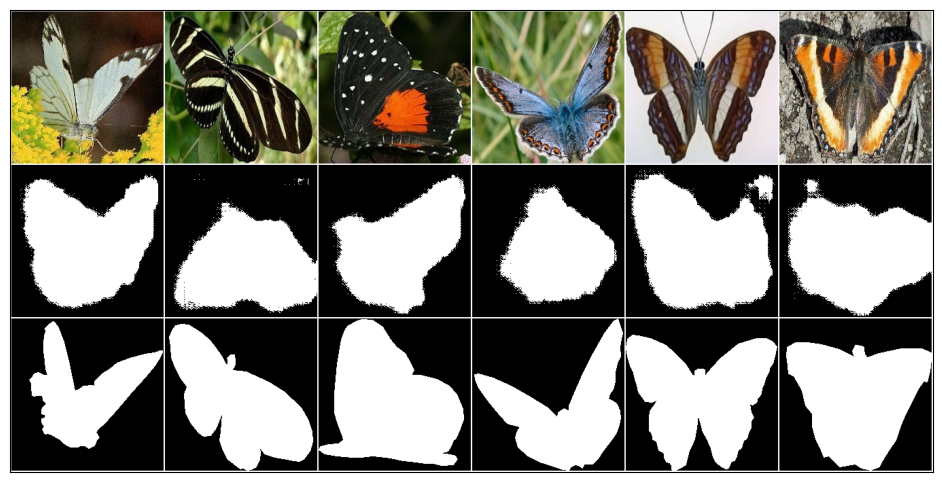

In [18]:
show_results(segmentation_model,test_loader,ht=224,wd=224,ch=3,to_display=6)   